# 3. CKY parsing

## Preparation

In [1]:
import matplotlib.pyplot as plt
import nltk

import time
from collections import defaultdict

from dataset import load_sentences, load_grammar
from parser import CkyParser
from measure import tree_f1_score


if False:   # Set this as True if it is your first time use NLTK grammer
    nltk.download("large_grammars")

In [2]:
# Grammar and corpus loading
grammar = load_grammar()
sentences = load_sentences()
parser = CkyParser(grammar)
print("Number of sentences:", len(sentences))
print(grammar)

Number of sentences: 98
Grammar with 16310 productions (start state = SIGMA)
    PTPRTCL_VBN -> 'stuck'
    AVPNP_NP -> 'friday'
    SIGMA -> __NOUN_CD__two__hundred__ fifty
    NP_ONS -> __NP_ONS__AVP_RB__ADJ_AT__ones__ PP_NN
    AJP_JJ -> 'finished'
    __DECL_BER__NP_NN__pt_verb_ber__NP_NNS__ -> __DECL_BER__NP_NN__pt_verb_ber__ NP_NNS
    SIGMA -> 'operation'
    AVPNP_NNS -> 'passengers'
    AVPNP_CD -> one a_m
    NP_NNS -> __NP_NNS__QUANP_DTI__NOUN_NNS__PP_NP__ pt_char_per
    INFCL_VB -> 'change'
    VP_VB -> 'plan'
    DECL_VBN -> __DECL_VBN__NP_NN__pt_verb_ber__VERB_VBN__PP_NNS__ pt_char_per
    DECL_VB -> __DECL_VB__pt_verb_do__NP_NNS__VERB_VB__NP_NN__ pt_char_per
    NOUN_NP -> 's'
    VERB_VBZ -> 'wants'
    __DECL_BEZ__pt_adv_wrb__VERB_BEZ__NP_NN__ -> __DECL_BEZ__pt_adv_wrb__VERB_BEZ__ NP_NN
    __IMPR_VB__VERB_VB__PP_NP__ -> VERB_VB PP_NP
    LABEL_CD -> __NOUN_CD__six__twenty__ two
    SIGMA -> __DECL_BEZ__NP_DT__VERB_BEZ__NP_NN__PP_NN__ pt_char_per
    PTPRTCL_VBN -> 'p

In [3]:
if True:   # Set it as True to calculate the ground truth counts on the fly, it will take ~1min
    nltk_parser = nltk.parse.BottomUpChartParser(grammar)
    gt_counts = [0] * len(sentences)
    for idx, senten in enumerate(sentences):
        try:
            chart = nltk_parser.chart_parse(senten)
        except ValueError:  # The parser will raise an ValueError with unknown words.
            continue
        gt_trees = list(chart.parses(grammar.start()))
        gt_counts[idx] = len(gt_trees)

    if False:   # Set it as True to save the ground truth counts into file.
        with open("../datasets/ground_truth_trees_counts.txt", "w", encoding="utf-8") as file:
            file.write("\n".join(map(str, gt_counts)))
else:
    with open("../datasets/ground_truth_trees_counts.txt", encoding="utf-8") as file:
        gt_counts = list(map(lambda x: int(x.strip()), file.readlines()))
    assert len(gt_counts) == len(sentences)

## Recognizer / Counter

Counter design: the core idea is, we record the counting on subtrees. When induce to the parent, the counting of the parent increases with the production of countings of children.

```
Data structure:
    Ch(i,k) eventually contains {A | A ⇒* wi ... wk-1}, initially all empty. 
    Counting(i,j,s) represents the number of parse trees of subsentence [i...j] with nonterminal s, initially all 0.

for each i from 1 to n:
    for each production rule A → w_i:
        add A to Ch(i, i+1)
        Counting(i,i+1,A) = 1

for each width b from 2 to n:
    for each start position i from 1 to n-b+1:
        for each left width k from 1 to b-1:
            for each B in Ch(i,i+k) and C in Ch(i+k,i+b):
                for each production rule A -> B C:
                    add A to Ch(i, i+b)
                    Counting(i,i+b,A) += Counting(i,i+k,B) * Counting(i+k,i+b,C)

Output: Counting(1,n,sigma)
```

In [4]:
grammatical_sentences = [
    "Hello .",
    "i am a flight .",
    "i am not a city .",
]
ungrammatical_sentences = [
    "I am ChatGPT .",
    "flight am a i .",
    "42 .",
    "Tatakai .",
    "Viva la Vida .",
]

# Test grammatical sentences
for senten in grammatical_sentences:
    assert parser.recognize(senten.lower().split())
    print(f"{senten:24} is grammatical")

print()

# Test ungrammatical sentences. It's notable that number and some words are unable to be recognized.
for senten in ungrammatical_sentences:
    assert not parser.recognize(senten.lower().split())
    print(f"{senten:24} is ungrammatical")

Hello .                  is grammatical
i am a flight .          is grammatical
i am not a city .        is grammatical

I am ChatGPT .           is ungrammatical
flight am a i .          is ungrammatical
42 .                     is ungrammatical
Tatakai .                is ungrammatical
Viva la Vida .           is ungrammatical


In [5]:
# Check my parse tree counts against the counts in NLTK, and print my parsing results
result_lines = list()
for senten, gt_cnt in zip(sentences, gt_counts):
    assert parser.count(senten) == gt_cnt
    result_lines.append(f"{' '.join(senten)}\t#{gt_cnt}")
    print(result_lines[-1])
if True:
    with open("parsing_results.txt", "w", encoding="utf-8") as file:
        file.write("\n".join(result_lines))

i need a flight from charlotte to las vegas that makes a stop in saint louis .	#2085
what is the cheapest one way flight from phoenix to san diego that arrives in the morning on thursday june second .	#1380
what is the cheapest one way flight from columbus to indianapolis .	#50
is there a flight from memphis to los angeles .	#18
what aircraft is this .	#0
please show me the flights from chicago to detroit that arrive at six p.m. next tuesday .	#20
what flights are available between chicago and indianapolis next wednesday between eleven a.m. and one p.m .	#0
please book a one way coach fare from chicago to indianapolis on united flight two ninety two next wednesday .	#0
show me flights from chicago to kansas city leaving around seven p.m. thursday .	#1059
show american flights after twelve p.m. from miami to chicago .	#0
does united flight four seven four slash fourteen eighty four serve dinner .	#0
what kind of aircraft is american 's flight fifteen oh one that departs at six fifty nin

**Discussion**

- Strange sentences that don't make sense can be grammatical. For example, nobody will say `i am a flight .`.
- What is judged as ungrammatical may not actually be ungrammatical. For example, `I am ChatGPT .` is grammatical (and also make sense). But it was refused by the parser because `ChatGPT` is a word that never occur in the grammar used by the parser.
- Sentences in other languages, e.g. `Tatakai .`, `Viva la Vida`​, ​are highly likely to be rejected for the same reason that their words not occur in the grammar.
- There should be only a few numbers, or even none, that can be identified. We might need a universal replacement word to preprocess all numbers.

## Parser

In [6]:
# Test the correctness
for senten, gt_cnt in zip(sentences, gt_counts):
    assert len(parser.parse(senten)) == gt_cnt

In [7]:
# Draw all the trees of a sentence with 4 parses
senten = sentences[-9]
trees = parser.parse(senten)
print(f"{' '.join(senten)}\t#{len(trees)}")

what are the costs .	#4


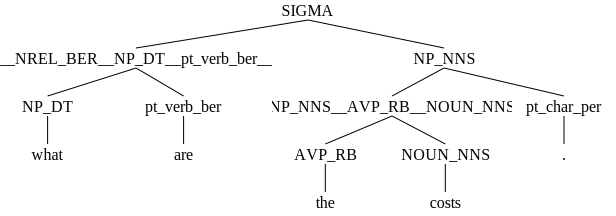

In [8]:
trees[0]

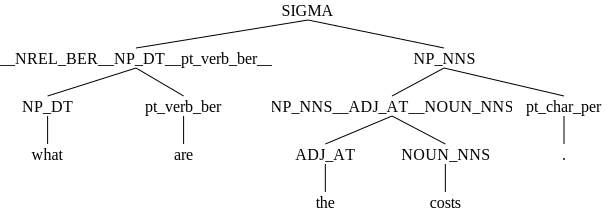

In [9]:
trees[1]

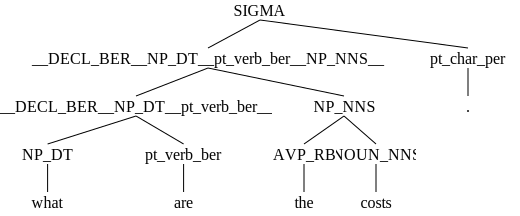

In [10]:
trees[2]

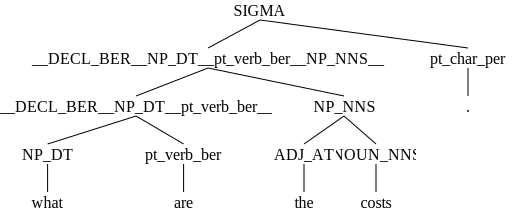

In [11]:
trees[3]

**Discussion**

The results could be grouped as two pairs. `trees[0]` and `trees[1]` are same in the structurs. `trees[2]` and `trees[3]` are also. Comparing inside the groups, we could found that the difference attributable to the `nonterminal` of word `the` for both the two groups.

I found the production rules below in `atis.cfg`:
```
ADJ_AT -> the
ADJ_AT -> a
ADJ_AT -> no
ADJ_AT -> pt_adj_at
```
and 
```
AVP_RB -> ADV_RB
ADV_RB -> the
the -> "the"
```

Because the CFG should reduce rules like `A -> B -> C -> T` into `A -> T`, the last two rules above should be reduced as `AVP_RB -> "the"`

By asking Gemini, I got:

> Q: what do non-terminal `NP_NNS`, `ADV_RB`, `AVP_RB`, and `ADJ_AT` mean in parsing task in NLP?
>
> `NP_NNS` (Noun Phrase rooted in a Plural Noun): A Noun Phrase where the head word is a plural noun.
>
> `ADJ_AT` (Article acting as an Adjective): An article (determiner) that is functionally categorized as a type of adjective in this specific grammar.
> 
> `AVP_RB` (Adverb Phrase): An Adverb Phrase headed by an adverb.
> 
> `ADV_RB` (Adverb Word): A specific Adverb word.

Based on the definitions given my Gemini, the conclusion is: Because the CFG do not care about the POS, `the` will be parsed as a component of `ADV` once, and then as a component of `ADJ` again. This resulted in two trees in each group.

# Extra Points

## Sentence Length vs. Time

In [12]:
def timer_ms(method, senten: list[str], gt_cnt: int) -> float:
    ns = time.time_ns()
    cnt = method(senten)
    ns = time.time_ns() - ns
    if not isinstance(cnt, int):
        cnt = len(cnt)
    assert cnt == gt_cnt
    return ns * 1e6 # Miliseconds

sentence_counts = defaultdict[int, int](lambda: 0)
trees_counts = defaultdict[int, int](lambda: 0)
counting_times = defaultdict[int, float](lambda: 0.0)
parsing_times = defaultdict[int, float](lambda: 0.0)
for senten, gt_cnt in zip(sentences, gt_counts):
    length = len(senten)
    sentence_counts[length] += 1
    trees_counts[length] += gt_cnt
    counting_times[length] += timer_ms(parser.count, senten, gt_cnt)
    parsing_times[length] += timer_ms(parser.parse, senten, gt_cnt)

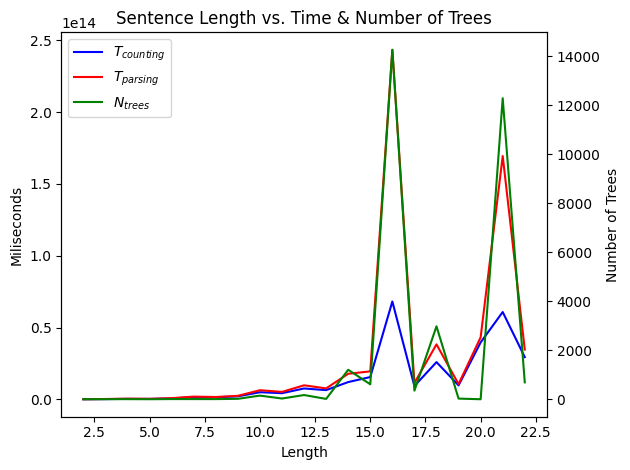

In [13]:
length = sorted(sentence_counts.keys())
ms_counting = [counting_times[k] / sentence_counts[k] for k in length]
ms_parsing = [parsing_times[k] / sentence_counts[k] for k in length]
num_trees = [trees_counts[k] / sentence_counts[k] for k in length]

line_a, = plt.plot(length, ms_counting, label="$T_{counting}$", c="b")
line_b, = plt.plot(length, ms_parsing, label="$T_{parsing}$", c="r")
plt.xlabel("Length") ; plt.ylabel("Miliseconds")

plt.twinx() ; plt.ylabel("Number of Trees")
line_c, = plt.plot(length, num_trees, label="$N_{trees}$", c="g")
plt.legend([line_a, line_b, line_c], [line_a.get_label(), line_b.get_label(), line_c.get_label()], loc="upper left")

plt.title("Sentence Length vs. Time & Number of Trees")
plt.tight_layout()
plt.show()

**Disscussion**

We can see that,
- In most cases, $T_{counting} < T_{parsing}$. Because `count()` methods perform CKY algorithm and calculate the number of trees without compute all the parse trees, the time is saved. When the results contain a large number of parse trees, the gaps of time are more distinguishable.
- The trends of the three curves are almost synchronized. Generally, the longer the sentence, the more computation time is required.

However, the time cost for some data points is unusually high. We can see that these data points are accompanied by a very large number of parse trees ($N_{trees}>10000$). This is caused by the inner loop of CKY algorithm:

```
for each B in Ch(i,i+k) and C in Ch(i+k,i+b):   # The scale increases with the number of trees
    for each production rule A -> B C:          # This is O(1) thanks to hash map (dict)
        add A to Ch(i, i+b)
```

## Labeled / Unlabeled Tree F1 Score

In [14]:
# Use the "But the concept is workable" example in the slide for parsing.
# Page 25 https://moodle.uni-saarland.de/pluginfile.php/890879/mod_resource/content/5/08%20PCFGs.pdf

# Hardcode the trees with post-order sequence
gold_postorder = [
    ("CC", "But"),
    ("DT", "the"),
    ("NN", "concept"),
    ("NP-SBJ", "DT", "NN"),
    ("VBZ", "is"),
    ("JJ", "workable"),
    ("ADJP", "JJ"),
    ("VP", "VBZ", "ADJP"),
    ("S", "CC", "NP-SBJ", "VP"),
]
parse_postorder = [
    ("IN", "But"),
    ("DT", "the"),
    ("NP", "DT"),
    ("PP", "IN", "NP"),
    ("NN", "concept"),
    ("NP-SBJ", "NN"),
    ("VBZ", "is"),
    ("JJ", "workable"),
    ("ADJP", "JJ"),
    ("VP", "VBZ", "ADJP"),
    ("S", "PP", "NP-SBJ", "VP"),
]


# Build trees from post-order sequence
def build_tree_from_postorder(postorder: list[tuple[str, ...]]) -> nltk.Tree:
    tmp_tree = dict[str, nltk.Tree | nltk.Nonterminal]()
    for nodes in postorder:
        if len(nodes) == 2 and nodes[-1] not in tmp_tree:  # Leaf
            assert isinstance(nodes[-1], str)
            tmp_tree[nodes[0]] = nltk.Nonterminal(nodes[0])
            continue
        tmp_tree[nodes[0]] = nltk.Tree(nodes[0], [tmp_tree.pop(x) for x in nodes[1:]])
    assert tmp_tree.keys() == {"S"}
    result = tmp_tree.pop("S")
    assert isinstance(result, nltk.Tree)
    return result

gold_tree = build_tree_from_postorder(gold_postorder)
parse_tree = build_tree_from_postorder(parse_postorder)

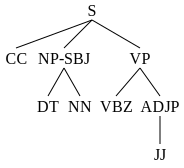

In [15]:
gold_tree

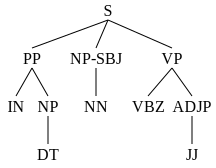

In [16]:
parse_tree

In [17]:
labeled_f1 = tree_f1_score(gold_tree, parse_tree, unlabeled=False)
unlabeled_f1 = tree_f1_score(gold_tree, parse_tree, unlabeled=True)
print("Labeled F1:", labeled_f1)    # Should be 0.700
print("Unlabeled F1:", tree_f1_score(gold_tree, parse_tree, unlabeled=True))    # Should be 0.899

Labeled F1: 0.7000000000000001
Unlabeled F1: 0.8988764044943819


## PCFG Building

In [18]:
# Counting the rules on the trees
leaf_counts = defaultdict[tuple[str, str], int](lambda: 0)          # (T <- NT) => count
nonleaf_counts = defaultdict[tuple[str, str, str], int](lambda: 0)  # (L R <- P) => count
left_hand_counts = defaultdict[str, int](lambda: 0)                 # NT | P => count

def traverse(tree: nltk.Tree) -> None:
    assert 1 <= len(tree) <= 2
    parent: str = tree.label()
    left_hand_counts[parent] += 1
    if len(tree) == 1:  # leaf
        child = tree[0]
        assert isinstance(child, str)
        leaf_counts[(child, parent)] += 1
        return
    left, right = tree
    assert isinstance(left, nltk.Tree) and isinstance(right, nltk.Tree)
    nonleaf_counts[(left.label(), right.label(), parent)] += 1
    traverse(left)
    traverse(right)

# Use the standard CKY Parser to produce all possible trees.
trees = sum([parser.parse(senten) for senten in sentences], [])
for t in trees: traverse(t)

# Build PCFG
leaf_probs = {k: v / left_hand_counts[k[-1]] for k, v in leaf_counts.items()}
nonleaf_probs = {k: v / left_hand_counts[k[-1]] for k, v in nonleaf_counts.items()}
productions = [
    nltk.ProbabilisticProduction(nltk.Nonterminal(k[-1]), [k[-2]], prob=v)
    for k, v in leaf_probs.items()
] + [
    nltk.ProbabilisticProduction(nltk.Nonterminal(k[-1]), (nltk.Nonterminal(kk) for kk in k[:-1]), prob=v)
    for k, v in nonleaf_probs.items()
]

pcfg = nltk.PCFG(grammar.start(), productions)
# assert pcfg.is_chomsky_normal_form()  # it's not CKF, because it does not contain the whole CFG. But it's enough for given sentences.
print(pcfg)

Grammar with 1948 productions (start state = SIGMA)
    NP_PPSS -> 'i' [0.999936]
    VERB_MD -> 'need' [0.222298]
    NOUN_NP -> 'a' [0.034373]
    NOUN_NN -> 'flight' [0.0368262]
    PREP_IN -> 'from' [0.335091]
    NOUN_NP -> 'charlotte' [0.00874029]
    PREP_IN -> 'to' [0.281971]
    las -> 'las' [1.0]
    vegas -> 'vegas' [1.0]
    NP_WPS -> 'that' [0.997166]
    VERB_VBZ -> 'makes' [0.561692]
    NP_NP -> 'a' [0.0368162]
    NOUN_NN -> 'stop' [0.00794938]
    PREP_IN -> 'in' [0.145356]
    saint -> 'saint' [1.0]
    louis -> 'louis' [1.0]
    pt_char_per -> '.' [1.0]
    ADJ_AT -> 'a' [0.356738]
    PREP_IN -> 'a' [0.0501992]
    NOUN_NP -> 'saint' [0.075918]
    NOUN_NP -> 'louis' [0.00335725]
    AVPNP_NP -> 'louis' [0.0668989]
    NAPPOS_NP -> 'louis' [0.0322045]
    NP_NP -> 'saint' [0.0379936]
    VERB_VB -> 'saint' [0.0786253]
    INFCL_VB -> 'stop' [0.00318314]
    AVP_RB -> 'to' [0.534586]
    INFCL_VB -> 'flight' [0.0114442]
    VERB_VB -> 'stop' [0.000496611]
    AVPNP_

## Viterbi CKY

In [19]:
FLOAT_EPS = 1e-7
pcfg_parser = nltk.parse.ViterbiParser(pcfg)
parser = CkyParser(pcfg)
all_gt_trees: list[nltk.ProbabilisticTree | None] = [None] * len(sentences)
all_trees = all_gt_trees.copy()

for idx, senten in enumerate(sentences):
    tree = parser.viterbi(senten, leaf_probs, nonleaf_probs)
    try:
        gt_tree = list[nltk.ProbabilisticTree](pcfg_parser.parse(senten))
    except ValueError:
        gt_tree = []
    if tree is None or len(gt_tree) == 0:
        assert tree is None and len(gt_tree) == 0 and gt_counts[idx] == 0
        continue

    assert len(gt_tree) == 1
    gt_tree = gt_tree[0]

    assert abs(gt_tree.logprob() - tree.logprob()) < FLOAT_EPS
    f1 = tree_f1_score(tree, gt_tree, unlabeled=False)
    if abs(f1 - 1.0) >= FLOAT_EPS:
        assert abs(tree_f1_score(tree, gt_tree, unlabeled=True) - 1.0) < FLOAT_EPS
        print(f"At {idx} found two different trees with same probability, with labeled-f1={f1:.4f} and unlabeled-f1={1.0}")
    all_trees[idx] = tree
    all_gt_trees[idx] = gt_tree

print("All tag trees generated by my ViterbiCKY have same probability as nltk.ViterbiParser")

All tag trees generated by my ViterbiCKY have same probability as nltk.ViterbiParser


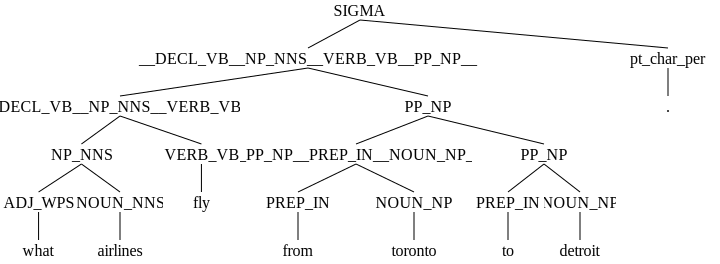

In [20]:
all_trees[60]

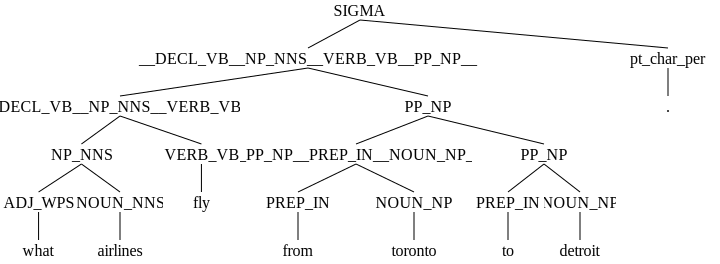

In [21]:
all_gt_trees[60]

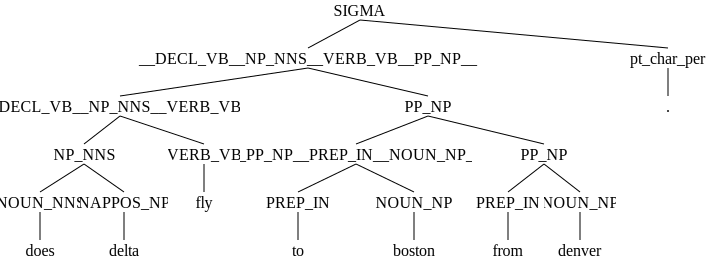

In [22]:
all_trees[75]

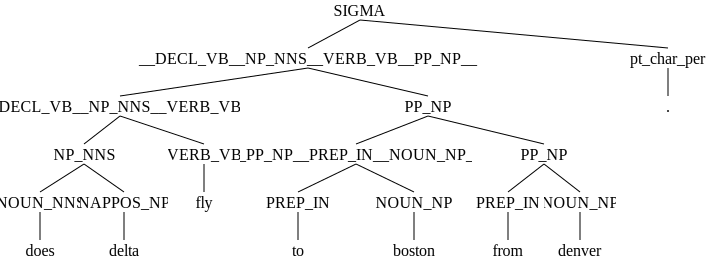

In [23]:
all_gt_trees[75]

In [24]:
print(pcfg.productions(lhs=nltk.Nonterminal("__NREL_VB__NP_NNS__VERB_VB__")))
print(pcfg.productions(lhs=nltk.Nonterminal("__DECL_VB__NP_NNS__VERB_VB__")))
# They are equal when producing in left-hand-side

[__NREL_VB__NP_NNS__VERB_VB__ -> NP_NNS VERB_VB [1.0]]
[__DECL_VB__NP_NNS__VERB_VB__ -> NP_NNS VERB_VB [1.0]]


In [25]:
print(pcfg.productions(rhs=nltk.Nonterminal("__NREL_VB__NP_NNS__VERB_VB__")))
print(pcfg.productions(rhs=nltk.Nonterminal("__DECL_VB__NP_NNS__VERB_VB__")))
# They are not equal when be produced in right-hand-side

[__NREL_VB__NP_NNS__VERB_VB__PP_NP__ -> __NREL_VB__NP_NNS__VERB_VB__ PP_NP [1.0]]
[__DECL_VB__NP_NNS__VERB_VB__NP_NN__ -> __DECL_VB__NP_NNS__VERB_VB__ NP_NN [1.0], __DECL_VB__NP_NNS__VERB_VB__NP_NP__ -> __DECL_VB__NP_NNS__VERB_VB__ NP_NP [1.0], __DECL_VB__NP_NNS__VERB_VB__PP_NP__ -> __DECL_VB__NP_NNS__VERB_VB__ PP_NP [1.0], __DECL_VB__NP_NNS__VERB_VB__PP_NN__ -> __DECL_VB__NP_NNS__VERB_VB__ PP_NN [1.0], __DECL_VB__NP_NNS__VERB_VB__AVPNP_NP__ -> __DECL_VB__NP_NNS__VERB_VB__ AVPNP_NP [1.0]]


In [26]:
print(pcfg.productions(lhs=nltk.Nonterminal("__NREL_VB__NP_NNS__VERB_VB__PP_NP__")))
print(pcfg.productions(lhs=nltk.Nonterminal("__DECL_VB__NP_NNS__VERB_VB__PP_NP__")))
# They are equal when producing in left-hand-side

[__NREL_VB__NP_NNS__VERB_VB__PP_NP__ -> __NREL_VB__NP_NNS__VERB_VB__ PP_NP [1.0]]
[__DECL_VB__NP_NNS__VERB_VB__PP_NP__ -> __DECL_VB__NP_NNS__VERB_VB__ PP_NP [1.0]]


In [27]:
print(pcfg.productions(rhs=nltk.Nonterminal("__NREL_VB__NP_NNS__VERB_VB__PP_NP__")))
print(pcfg.productions(rhs=nltk.Nonterminal("__DECL_VB__NP_NNS__VERB_VB__PP_NP__")))
# They are not equal when be produced in right-hand-side

[SIGMA -> __NREL_VB__NP_NNS__VERB_VB__PP_NP__ pt_char_per [0.0113324], __NREL_VB__NP_NNS__VERB_VB__PP_NP__PP_NP__ -> __NREL_VB__NP_NNS__VERB_VB__PP_NP__ PP_NP [1.0]]
[SIGMA -> __DECL_VB__NP_NNS__VERB_VB__PP_NP__ pt_char_per [0.0113324], __DECL_VB__NP_NNS__VERB_VB__PP_NP__PP_NP__ -> __DECL_VB__NP_NNS__VERB_VB__PP_NP__ PP_NP [1.0], __DECL_VB__NP_NNS__VERB_VB__PP_NP__PP_NN__ -> __DECL_VB__NP_NNS__VERB_VB__PP_NP__ PP_NN [1.0]]


**Discussion**

It's interested that I obtained two pair of trees with f1 != 1 but with same probability. By checking the plots, I found these special pairs. By checking and comparing these pairs, I found that:
- Nonterminals in each pairs are equal when they are in the left-hand-side to produce other non terminals, e.g. both `__NREL_VB__NP_NNS__VERB_VB__` and `__DECL_VB__NP_NNS__VERB_VB__` produces and only produces `NP_NNS VERB_VB` with probability 1.0.
- However, nonterminals in each pairs are not equal when they are in right-hand-side to be produced by other non terminals, e.g. `__NREL_VB__NP_NNS__VERB_VB__` can only be produced by exactly one rule `__NREL_VB__NP_NNS__VERB_VB__PP_NP__ -> __NREL_VB__NP_NNS__VERB_VB__ PP_NP`, while `__DECL_VB__NP_NNS__VERB_VB__` can be produced by multiple rules.

This means that nonterminals in each pairs, although appear equivalent in the results, are actually **inequivalent** in the CFG. For example, `__NREL_VB__NP_NNS__VERB_VB__` paired with `PP_NP` is grammatical, while it could not be paired with `NP_NN`. On the contrary, `__DECL_VB__NP_NNS__VERB_VB__` could be paired with `NP_NN`.